# **Ensemble Trees Exercise**

_John Andrew Dixon_

---

**Setup**

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [227]:
# Remote URL to the data
url ="https://docs.google.com/spreadsheets/d/e/2PACX-1vSQc1CsJ25nPMJcuJD04csFCysrzuInd_IQ_drLza49m_3R4MllPcuhduu4GozMJun3MgUJkGl0cw-d/pub?output=csv"
# Load and verify data
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   NOX      506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   PTRATIO  506 non-null    float64
 5   LSTAT    506 non-null    float64
 6   PRICE    506 non-null    float64
dtypes: float64(7)
memory usage: 27.8 KB


In [228]:
# Function for evaluating regression R^2 scores
def metrics(regressor, training, testing):
    """Function for evaluating a model's R^2 scores"""
    predictions = {
        "training": regressor.predict(training["X"]),
        "testing": regressor.predict(testing["X"])
    }

    metrics_df = pd.DataFrame({
        "R2": [regressor.score(training["X"], training["y"]), regressor.score(testing["X"], testing["y"])],
        "MAE": [mean_absolute_error(training["y"], predictions["training"]), mean_absolute_error(testing["y"], predictions["testing"])],
        "MSE": [mean_squared_error(training["y"], predictions["training"]), mean_squared_error(testing["y"], predictions["testing"])],
        "RMSE": [np.sqrt(mean_squared_error(training["y"], predictions["training"])), np.sqrt(mean_squared_error(testing["y"], predictions["testing"]))]
    }, index=["Training", "Testing"])
    return metrics_df

---

## **Tasks**

### **Try a Decision Tree, Bagged Tree, and Random Forest.**

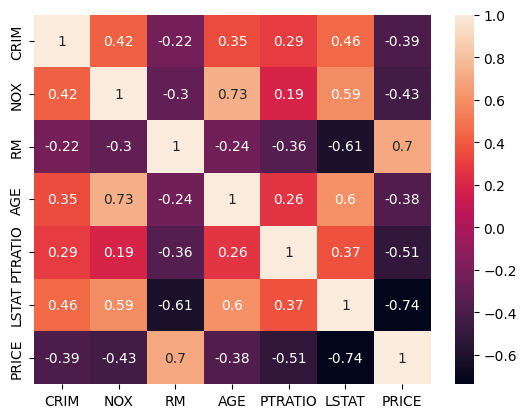

In [229]:
# Column correlations
correlations = df.corr()
# Heatmap of the column correlations
sns.heatmap(correlations, annot=True);

Since all features have some correlation with `PRICE` I will select all for my feature maxtrix.

In [230]:
# Create feature matrix and target vector
X = df.drop(columns="PRICE")
y = df["PRICE"]

In [231]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
training_set = {"X": X_train, "y": y_train}
testing_set = {"X": X_test, "y": y_test}

In [232]:
# Bring default trees and forest regressors into the mix
dt_default = DecisionTreeRegressor(random_state=42)
bt_default = BaggingRegressor(random_state=42)
rf_default = RandomForestRegressor(random_state=42)

In [233]:
# Fit all of them to the training data
dt_default.fit(X_train, y_train)
bt_default.fit(X_train, y_train)
rf_default.fit(X_train, y_train)
print(end='')

In [234]:
print("DecisionTreeRegressor")
display(metrics(dt_default, training_set, testing_set))
print("BaggingRegressor")
display(metrics(bt_default, training_set, testing_set))
print("RandomForestRegressor")
metrics(rf_default, training_set, testing_set)

DecisionTreeRegressor


,R2,MAE,MSE,RMSE
Training,1.000000,0.000000,0.000000,0.000000
Testing,0.619323,3.140945,26.657717,5.163111


BaggingRegressor


,R2,MAE,MSE,RMSE
Training,0.960676,1.103325,3.487356,1.867446
Testing,0.820421,2.315512,12.575417,3.546183


RandomForestRegressor


,R2,MAE,MSE,RMSE
Training,0.977134,0.953546,2.027774,1.423999
Testing,0.833853,2.207858,11.634795,3.410981


### **Tune each model to optimize performance on the test set.**
- After using a loop to tune each model, remember to create the best version of the model using the best hyperparameter values for the model based on the metrics you generated in your loop. The metrics from this best version model are what you will compare to the metrics of the other best version models to determine the overall best model.

#### **Decision Tree Tuning**

In [235]:
# DataFrame to hold the depth tuning
tuning = pd.DataFrame({
    "Depth": [],
    "Train R-Squared": [],
    "Test R-Squared": []
})

# Loop through pontential parameters
for number in range(1, 51):
    temp = DecisionTreeRegressor(max_depth=number, random_state=42)
    temp.fit(X_train, y_train)
    metrics_df = metrics(temp, training_set, testing_set).T
    tuning.loc[len(tuning)] = [number, metrics_df.iloc[0][0], metrics_df.iloc[0][1]]

# Get the depth that has the best test R^2
best_depth = tuning.sort_values("Test R-Squared", ascending=False).head(1).iloc[0, 0]

In [236]:
# Get the best decision tree
dt_best = DecisionTreeRegressor(max_depth=int(best_depth), random_state=42)
dt_best.fit(X_train, y_train)
metrics(dt_best, training_set, testing_set)

,R2,MAE,MSE,RMSE
Training,0.958517,1.34673,3.678790,1.918017
Testing,0.846377,2.44725,10.757792,3.279907


#### **Bagged Tree Tuning**

In [237]:
# DataFrame to hold the n-estimator tuning
tuning = pd.DataFrame({
    "N-Estimators": [],
    "Train R-Squared": [],
    "Test R-Squared": []
})

# Loop through pontential parameters
for number in range(1, 101, 1):
    temp = BaggingRegressor(n_estimators=number, random_state=42)
    temp.fit(X_train, y_train)
    metrics_df = metrics(temp, training_set, testing_set).T
    tuning.loc[len(tuning)] = [number, metrics_df.iloc[0][0], metrics_df.iloc[0][1]]

# Get the n-estimator that has the best test R^2
best_n_estimator = tuning.sort_values("Test R-Squared", ascending=False).head(1).iloc[0, 0]

In [238]:
# Get the best bagged tree
bt_best = BaggingRegressor(n_estimators=int(best_n_estimator), random_state=42)
bt_best.fit(X_train, y_train)
metrics(bt_best, training_set, testing_set)

,R2,MAE,MSE,RMSE
Training,0.964612,1.096570,3.138241,1.771508
Testing,0.837922,2.286024,11.349860,3.368955


#### **Random Forest Tuning**

In [239]:
# DataFrame to hold the depth and n-estimator tunings
tuning = pd.DataFrame({
    "Depth": [],
    "N-Estimators": [],
    "Train R-Squared": [],
    "Test R-Squared": []
})
# Loop through pontential parameters
for depth in range(1, 51):
    for estimator in range(1, 51):
        temp = RandomForestRegressor(max_depth=depth, n_estimators=estimator, random_state=42)
        temp.fit(X_train, y_train)
        metrics_df = metrics(temp, training_set, testing_set).T
        tuning.loc[len(tuning)] = [depth, estimator, metrics_df.iloc[0][0], metrics_df.iloc[0][1]]

best_depth = tuning.sort_values("Test R-Squared", ascending=False).head(1).iloc[0, 0]
best_n_estimator = tuning.sort_values("Test R-Squared", ascending=False).head(1).iloc[0, 1]

In [240]:
# Get the best random forest
rf_best = RandomForestRegressor(max_depth=int(best_depth), n_estimators=int(best_n_estimator), random_state=42)
rf_best.fit(X_train, y_train)
metrics(rf_best, training_set, testing_set)

,R2,MAE,MSE,RMSE
Training,0.960260,1.239037,3.524253,1.877299
Testing,0.845709,2.233049,10.804581,3.287032


#### **Model Comparisons**

In [241]:
# Print out metrics for all models
print("DecisionTreeRegressor")
display(metrics(dt_best, training_set, testing_set))
print("BaggingRegressor")
display(metrics(bt_best, training_set, testing_set))
print("RandomForestRegressor")
metrics(rf_best, training_set, testing_set)

DecisionTreeRegressor


,R2,MAE,MSE,RMSE
Training,0.958517,1.34673,3.678790,1.918017
Testing,0.846377,2.44725,10.757792,3.279907


BaggingRegressor


,R2,MAE,MSE,RMSE
Training,0.964612,1.096570,3.138241,1.771508
Testing,0.837922,2.286024,11.349860,3.368955


RandomForestRegressor


,R2,MAE,MSE,RMSE
Training,0.960260,1.239037,3.524253,1.877299
Testing,0.845709,2.233049,10.804581,3.287032


The decision tree is the best model after all three were tuned.

### **Evaluate your best model using multiple regression metrics.**

In [242]:
print("DecisionTreeRegressor")
display(metrics(dt_best, training_set, testing_set))

DecisionTreeRegressor


,R2,MAE,MSE,RMSE
Training,0.958517,1.34673,3.678790,1.918017
Testing,0.846377,2.44725,10.757792,3.279907


### **Explain in a text cell how your model will perform if deployed by referring to the metrics.  Ex. How close can your stakeholders expect its predictions to be to the true value?**

Using MAE, we can expect our predictions to be off, on average, by about $2450. Likewise, we can expect our model to make fairly small errors, since RMSE is pretty close to MAE. This means the predicted values would likely be closer to the actual values and if they aren't the error between the two typically won't be large. Finally, looking at R2, we can confidently say that the model can explain almost 85% of the predicted values, meaning the predictions are likely close to the true values.